In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
from causalml.metrics.visualize import get_cumgain
from causalml.metrics import auuc_score, plot
from causalml.inference.tree import UpliftRandomForestClassifier

import plotMethods

%load_ext autoreload
%aimport plotMethods
%autoreload 1

np.random.seed(42) 

# Uplift modeling - which customers to target?

Modern world is full of advertisements and those are becoming more and more targeted. To win our attention, companies adapt to e.g. our digital viewing habits, collect our demographic data and then use this information to sell us things they think we may like. By focusing on specific traits, interests and preferences of a customer, targeted marketing is trying to **maximize the incremental impact of the promoted product**.

But how do these marketing campaigns identify the right individuals to send discount coupons or personalized advertisements to? Certainly, running those campaigns incurs financial costs, and it is unfeasible to send discount coupons to everyone in the world. The cost of printing the coupons and the lost of potential revenues, resulting from the offered discount, might just outweigh the additional profits generated from new customers. In addition, what if the customer was already planning to buy the advertised coupon, without receiving any extra discounts or adverts? In that case, the retailer would generate less profit, as the customer will be paying less than what they already intended to pay. So how do you identify individuals who are **only likely to purchase** your product **if targeted by the marketing campaign**?

## Dataset

Here, we will be using data provided by *Udacity* as part of their *Data Scientist Nanodegree*. This dataset was originally used as a take-home assignment given out by Starbucks during job application process. The data consists of about 120,000 data points split in a 2:1 ratio between training and testing sets. In the experiment, simulated by the data, Starbucks is about to launch a new marketing campaign based on sending promotional materials to selected customers. The team has run a randomized pilot (A/B testing) to test this campaign. In the pilot, a subset of customers was divided into two groups, only one of which received the promotion. The team recorded each customer's buying decision along with 7 features (*V1-V7*) encoding their personal characteristics. Based on the gathered data, we now want to know which other customers should be assigned to this campaign, in a way that would maximize generated profit. Since it costs the company *0.15* to contact each person, it would be best to limit the campaign only to the most receptive customers. As such, rather than predicting which customers would buy the product, we want to predict which customers would buy the product **only if contacted** (interaction).

## Goal

Our goal is to maximize the **profit of the campaign**:

$profit = \sum \limits _{i=1} ^{N} 10*purchase_{i}(decision_{i}) - 0.15*decision_{i}$,

where *purchase* is a purchasing decision of an individual client influenced by the *decision* - a binary indicator of whether that person has been targeted or not.

To account for the fact that some customers buy the product even if not targeted, we should also look at the **net incremental profit**, defined as:

$NIR = profit-10*nControlPurchase$,

where *nControlPurchase* is the number of people, who were not targeted and bought the service.

Furthermore, Starbucks asked their job candidates to also optimize the **incremental response rate**, defined as:

$IRR = \frac{nTreatPurchase}{nTreat} - \frac{nControlPurchase}{nControl}$, 

where *nTreatPurchase* is the number of people, who were not targeted and bought the service; and *nTreat* and *nControl* are the number of targeted and non-targeted customers respectively.

For this assignment, Starbucks claimed to have a model that achieved a NIR of 189.45 and an IRR of 1.88%. Note that this assignment is quite outdated though and it is very likely that Starbucks will have a better model now! Yet, these numbers will serve us as the benchmarks to beat.

## The approach

The problem of deciding whether it is profitable to target a particular customer can be tackled from two different perspectives:

1. traditional predictive modeling, where the problem is treated as a common classification task
2. uplift modeling, where the incremental probability of purchase is modeled

Here, we're going to compare both of those perspectives and use a total of four different approaches to choosing which customers to target:

1. [Traditional predictive model](./1.Classical-predictive-models.ipynb) 
2. [S-learner model (one-model "uplift classifier")](./2.S-learner.ipynb)
3. [T-learner model (two-models "uplift classifier")](./3.T-learner.ipynb) 
4. [Direct uplift modeling](./4.Direct-uplift.ipynb) 

# Comparing the models

We have now tuned and trained all of our models, so we can now compare them on an out-of-sample test set and benchmark their performance against that achieved by the Starbucks team.

First, let's read in our out-of-sample test data.


In [2]:
dataTest = pd.read_csv("data/test.csv")
dataTest['Promotion'] = dataTest['Promotion'].replace({'No': 0, 'Yes': 1})
dataTest.columns = ['ID', 'promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [3]:
plotMethods.eda(dataTest)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
ID,int64,41650,0,41650,63339.155774,36441.521173,2.000000,126178.000000,-1.200311,-0.011137
promotion,int64,41650,0,2,0.498151,0.500003,0.000000,1.000000,-2.000041,0.007395
purchase,int64,41650,0,2,0.011525,0.106734,0.000000,1.000000,81.792455,9.153607
V1,int64,41650,0,4,1.493469,0.864138,0.000000,3.000000,-0.660627,0.009315
V2,float64,41650,0,41644,29.986774,4.981025,9.202546,55.107509,-0.015723,0.012772
V3,float64,41650,0,40,-0.000387,0.999026,-1.684550,1.691984,-1.202408,-0.000653
V4,int64,41650,0,2,1.680792,0.466175,1.000000,2.000000,-1.398390,-0.775678
V5,int64,41650,0,4,2.319256,0.845162,1.000000,4.000000,-0.754926,-0.042149
V6,int64,41650,0,4,2.505642,1.119879,1.000000,4.000000,-1.364119,-0.009341
V7,int64,41650,0,2,1.704010,0.456492,1.000000,2.000000,-1.201077,-0.893857


### Classical predictive model - Random Forest

In [4]:
features = list(dataTest.iloc[:,3:].select_dtypes(exclude='object').columns)
X = dataTest[features]

In [5]:
rfClassical = joblib.load('models/rf-model-trained')
rfClassical_pred = rfClassical.predict(X)
rfClassical_probs = rfClassical.predict_proba(X)[:,1]

### S-learner - Random Forest

In [6]:
features = list(dataTest.iloc[:,3:].select_dtypes(exclude='object').columns) + ['promotion']

X0 = dataTest[features]
X1 = X0.copy()

X0.loc[:, 'promotion'] = 0
X1.loc[:, 'promotion'] = 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
rfSlearn = joblib.load('models/rf-slearn-trained')
Slearn_probs = rfSlearn.predict_proba(X1)[:,1] - rfSlearn.predict_proba(X0)[:,1]

### T-learner - XGBoost

In [8]:
features = list(dataTest.iloc[:,3:].select_dtypes(exclude='object').columns)
X = dataTest[features]

In [9]:
xgbTlearnTreat = joblib.load('models/xgb-tlearn-treat-trained')
xgbTlearnControl = joblib.load('models/xgb-tlearn-control-trained')
Tlearn_probs = xgbTlearnTreat.predict_proba(X)[:,1] - xgbTlearnControl.predict_proba(X)[:,1]

### Direct modeling - Uplift Forest

In [10]:
features = list(dataTest.iloc[:,3:].select_dtypes(exclude='object').columns)
X = dataTest[features]

In [11]:
scaler = copy.deepcopy(rfSlearn.named_steps.columntransformer.named_transformers_.num)
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'promotion'],
       dtype=object),
 'n_features_in_': 8,
 'n_samples_seen_': 76080,
 'mean_': array([ 1.50049947e+00,  2.99730569e+01, -7.36198735e-04,  1.67954784e+00,
         2.32798370e+00,  2.50316772e+00,  1.70140641e+00,  5.00552050e-01]),
 'var_': array([ 0.75470532, 25.05698133,  1.00123703,  0.21776257,  0.70794983,
         1.24757146,  0.20943546,  0.2499997 ]),
 'scale_': array([0.86873778, 5.00569489, 1.00061832, 0.46665037, 0.84139754,
        1.11694738, 0.45764119, 0.4999997 ])}

In [12]:
scaler.feature_names_in_ = scaler.feature_names_in_[:-1]
scaler.n_features_in_ = 7
scaler.mean_ = scaler.mean_[:-1]
scaler.var_ = scaler.var_[:-1]
scaler.scale_ = scaler.scale_[:-1]
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'], dtype=object),
 'n_features_in_': 7,
 'n_samples_seen_': 76080,
 'mean_': array([ 1.50049947e+00,  2.99730569e+01, -7.36198735e-04,  1.67954784e+00,
         2.32798370e+00,  2.50316772e+00,  1.70140641e+00]),
 'var_': array([ 0.75470532, 25.05698133,  1.00123703,  0.21776257,  0.70794983,
         1.24757146,  0.20943546]),
 'scale_': array([0.86873778, 5.00569489, 1.00061832, 0.46665037, 0.84139754,
        1.11694738, 0.45764119])}

In [13]:
Xpreproc = scaler.transform(X)

In [14]:
upModel = joblib.load('models/direct-uplift-trained')
up_probs = upModel.predict(X=Xpreproc)

## Model comparison

Let's now see our models did in comparison to one another.

In [15]:
Xuplift = dataTest.copy()
Xuplift['classical'] = rfClassical_probs
Xuplift['s_learn'] = Slearn_probs
Xuplift['t_learn'] = Tlearn_probs
Xuplift['uplift_forest'] = up_probs

Text(0, 0.5, 'Cumulative gain')

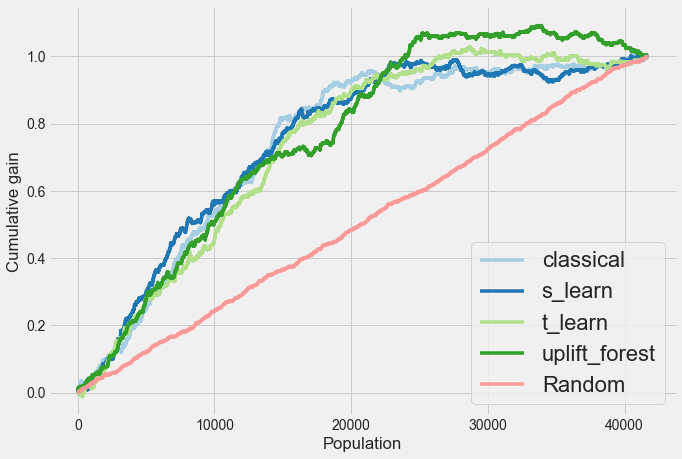

In [16]:
gain = get_cumgain(Xuplift[['classical', 's_learn', 't_learn', 'uplift_forest', 'purchase', 'promotion']], outcome_col='purchase', treatment_col='promotion', normalize=True)
fig, ax = plt.subplots(figsize=(10,7))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.lineplot(data=gain, dashes=False, ax=ax)
sns.despine()
plt.xlabel("Population")
plt.ylabel("Cumulative gain")

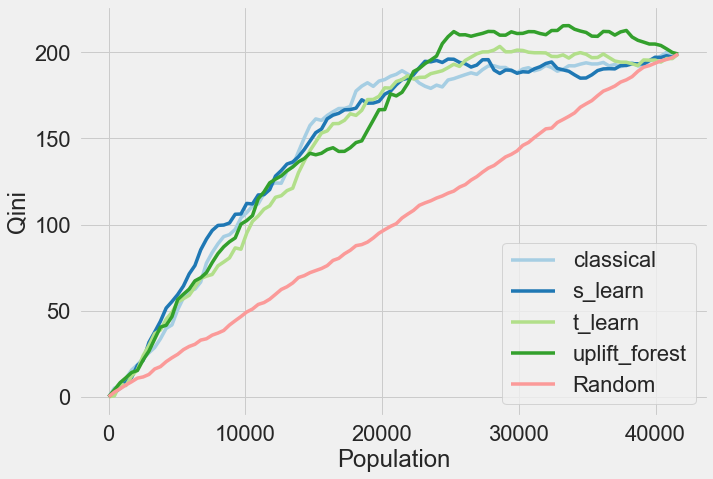

In [17]:
plot(Xuplift[['classical', 's_learn', 't_learn', 'uplift_forest', 'purchase', 'promotion']], kind='qini', outcome_col='purchase', treatment_col='promotion', figsize=(10, 7))

In [18]:
AUUC = auuc_score(Xuplift[['classical', 's_learn', 't_learn', 'uplift_forest', 'purchase', 'promotion']], outcome_col='purchase', treatment_col='promotion', normalize=True)
print("Random AUUC: {:.3f}\nClassical {:.3f}\nS-learner {:.3f}\nT-learner {:.3f}\nUplift forest {:.3f}".format(AUUC[4], AUUC[0], AUUC[1], AUUC[2], AUUC[3]))

Random AUUC: 0.505
Classical 0.742
S-learner 0.748
T-learner 0.738
Uplift forest 0.763


Well, we can see that the AUUC score of all of our models is much lower than for the training and dev data. What's more - all our models perform very similarly with respect to AUUC, even our classical random forest. The direct uplift model does take the lead though.

Let us also take a look at the NIR and IIR scores.

Text(0.5, 1.0, 'Classical RF model')

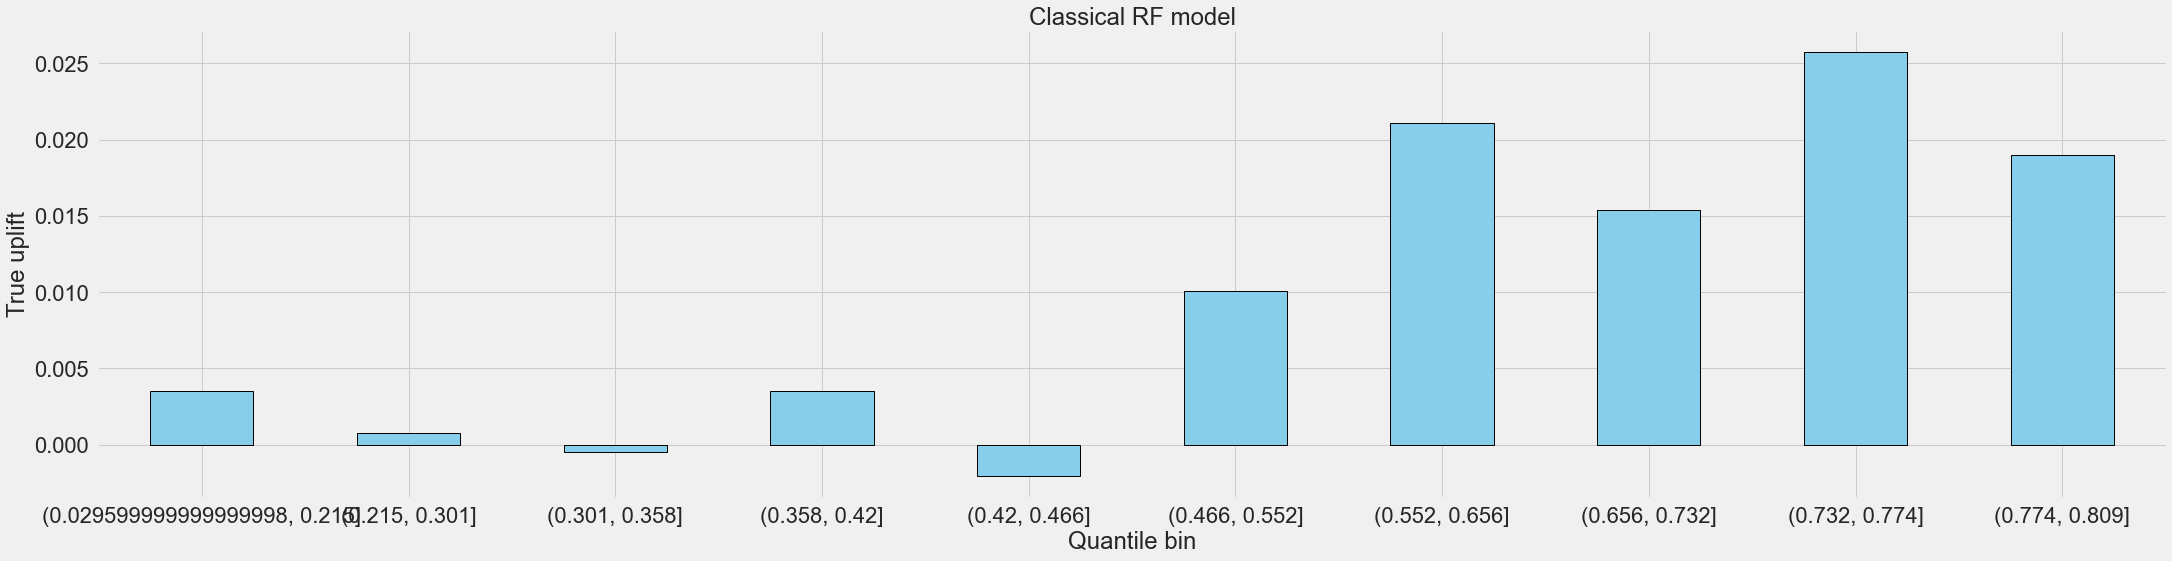

In [19]:
upliftQuant, upliftQuant_bins = pd.qcut(x=Xuplift['classical'], q=10, retbins=True, duplicates='drop')
Xuplift['quant'] = upliftQuant
QuantTarget = Xuplift.query('promotion == 1').groupby('quant')['purchase'].mean()
QuantControl = Xuplift.query('promotion == 0').groupby('quant')['purchase'].mean()
quantUp = QuantTarget - QuantControl

fig, ax = plt.subplots(figsize=(33,8))
quantUp.plot(kind="bar", stacked=True, color="skyblue", edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('Quantile bin')
plt.ylabel('True uplift')
plt.title('Classical RF model')

Text(0.5, 1.0, 'S-learn model')

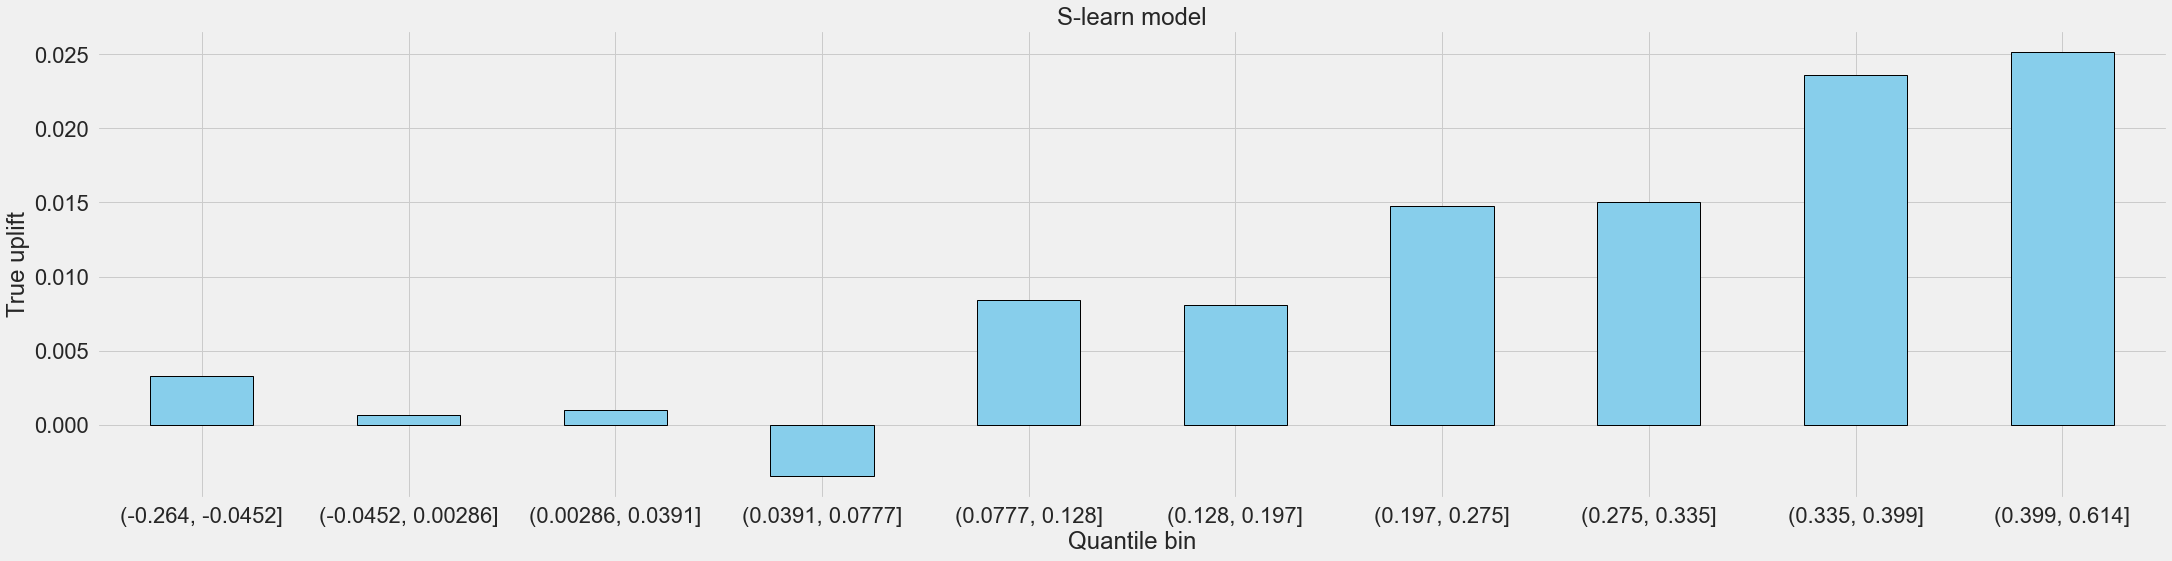

In [20]:
upliftQuant, upliftQuant_bins = pd.qcut(x=Xuplift['s_learn'], q=10, retbins=True, duplicates='drop')
Xuplift['quant'] = upliftQuant
QuantTarget = Xuplift.query('promotion == 1').groupby('quant')['purchase'].mean()
QuantControl = Xuplift.query('promotion == 0').groupby('quant')['purchase'].mean()
quantUp = QuantTarget - QuantControl

fig, ax = plt.subplots(figsize=(33,8))
quantUp.plot(kind="bar", stacked=True, color="skyblue", edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('Quantile bin')
plt.ylabel('True uplift')
plt.title('S-learn model')

Text(0.5, 1.0, 'T-learn model')

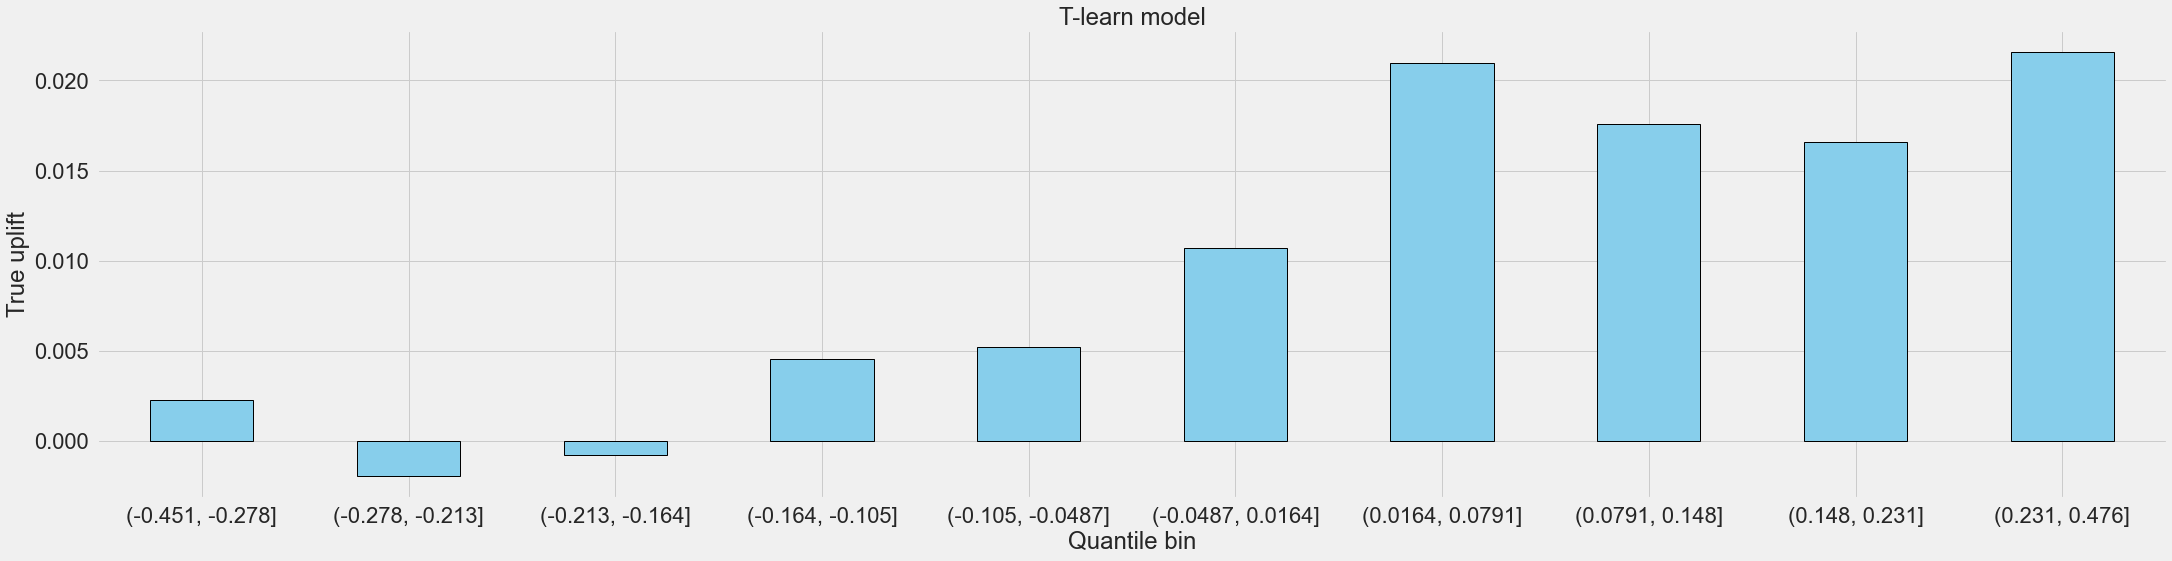

In [21]:
upliftQuant, upliftQuant_bins = pd.qcut(x=Xuplift['t_learn'], q=10, retbins=True, duplicates='drop')
Xuplift['quant'] = upliftQuant
QuantTarget = Xuplift.query('promotion == 1').groupby('quant')['purchase'].mean()
QuantControl = Xuplift.query('promotion == 0').groupby('quant')['purchase'].mean()
quantUp = QuantTarget - QuantControl

fig, ax = plt.subplots(figsize=(33,8))
quantUp.plot(kind="bar", stacked=True, color="skyblue", edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('Quantile bin')
plt.ylabel('True uplift')
plt.title('T-learn model')

Text(0.5, 1.0, 'Direct uplift model')

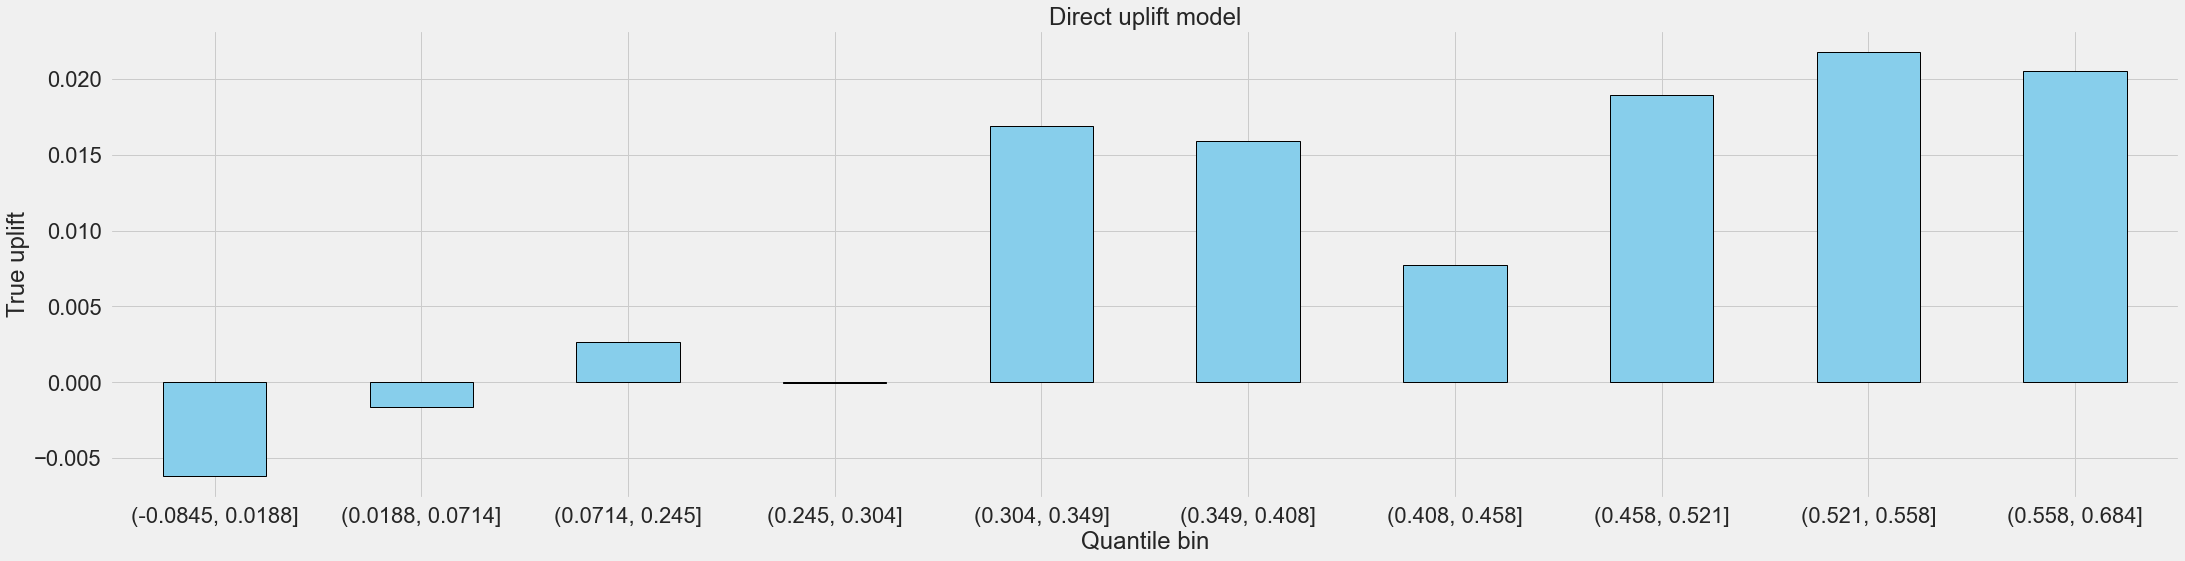

In [22]:
upliftQuant, upliftQuant_bins = pd.qcut(x=Xuplift['uplift_forest'], q=10, retbins=True, duplicates='drop')
Xuplift['quant'] = upliftQuant
QuantTarget = Xuplift.query('promotion == 1').groupby('quant')['purchase'].mean()
QuantControl = Xuplift.query('promotion == 0').groupby('quant')['purchase'].mean()
quantUp = QuantTarget - QuantControl

fig, ax = plt.subplots(figsize=(33,8))
quantUp.plot(kind="bar", stacked=True, color="skyblue", edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('Quantile bin')
plt.ylabel('True uplift')
plt.title('Direct uplift model')

In [23]:
toDrop = Xuplift.query('promotion == 0 and purchase == 0').index
NoPurchValid = Xuplift.drop(toDrop)
plotMethods.eda(NoPurchValid)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,type,count,missing,unique,mean,std,min,max,kurtosis,skew
ID,int64,20889,0,20889,63459.990617,36382.029028,6,126178,-1.190201,-0.013141
promotion,int64,20889,0,2,0.993250,0.081882,0,1,143.190291,-12.048924
purchase,int64,20889,0,2,0.022979,0.149839,0,1,38.551783,6.367738
V1,int64,20889,0,4,1.497487,0.866526,0,3,-0.667957,0.007074
V2,float64,20889,0,20888,29.978235,5.019800,9.202546,50.633056,-0.030184,0.002299
V3,float64,20889,0,40,0.004593,0.995633,-1.68455,1.691984,-1.193178,-0.008143
V4,int64,20889,0,2,1.683948,0.464944,1,2,-1.373902,-0.791347
V5,int64,20889,0,4,2.315956,0.846589,1,4,-0.755193,-0.031650
V6,int64,20889,0,4,2.501077,1.119280,1,4,-1.362813,-0.004846
V7,int64,20889,0,2,1.706161,0.455530,1,2,-1.180662,-0.905235


In [24]:
profit = {'classical': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['classical']>0.466).astype(int)),
          's-learn': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['s_learn']>0.0777).astype(int)),
          't-learn': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['t_learn']>0.0164).astype(int)),
          'direct uplift': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['uplift_forest']>0.304).astype(int))}

profit

{'classical': 1777, 's-learn': 1773, 't-learn': 1598, 'direct uplift': 1924}

In [25]:
NIR = {'classical': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['classical']>0.466).astype(int))
                    - (len(NoPurchValid.query('classical > 0.466 and purchase == 1 and promotion == 0')) * 10),
          's-learn': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['s_learn']>0.0777).astype(int))
                     - (len(NoPurchValid.query('s_learn > 0.0777 and purchase == 1 and promotion == 0')) * 10),
          't-learn': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['t_learn']>0.0164).astype(int))
                     - (len(NoPurchValid.query('t_learn > 0.0164 and purchase == 1 and promotion == 0')) * 10),
          'direct uplift': plotMethods.incremental_profit_score(NoPurchValid['purchase'], (NoPurchValid['uplift_forest']>0.304).astype(int))
                           - (len(NoPurchValid.query('uplift_forest > 0.304 and purchase == 1 and promotion == 0')) * 10)}

NIR

{'classical': 1037, 's-learn': 923, 't-learn': 958, 'direct uplift': 1064}

In [27]:
IRR = {'classical': plotMethods.IRRscore(NoPurchValid['purchase'], (NoPurchValid['classical']>0.466).astype(int)) * 100,
          's-learn': plotMethods.IRRscore(NoPurchValid['purchase'], (NoPurchValid['s_learn']>0.0777).astype(int)) * 100,
          't-learn': plotMethods.IRRscore(NoPurchValid['purchase'], (NoPurchValid['t_learn']>0.0164).astype(int)) * 100,
          'direct uplift': plotMethods.IRRscore(NoPurchValid['purchase'], (NoPurchValid['uplift_forest']>0.304).astype(int)) * 100}

IRR

{'classical': 1.812544304181787,
 's-learn': 1.5381664903601695,
 't-learn': 1.8781950903829587,
 'direct uplift': 1.8456511267052749}

While all our models have slightly lower IRR than the model trained by Starbucks (1.88%), all of them massively outperform Starbucks' model in terms of NIR. While Starbucks model has been reported to generate 189.45$,
our best performing model (uplift forest) generates 1064$. This is over 5 times improvement.